## Model

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 3개 파일을 불러왔습니다: 1201.csv, 401.csv, 89.csv
📊 데이터 Shape: I=3, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=768.00, M2=1202.00


In [ ]:
set = gp.Model("set")
set.setParam("MIPGap", 1e-7)

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")

yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p1")
p2 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p2")
p3 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p3")
p4 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p4")

set.update()

obj = gp.quicksum(P_DA[t] * gp.quicksum(x[i, t] for i in range(I)) for t in range(T)) + gp.quicksum((1 / S) * (P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in range(I)) - P_PN[t] * gp.quicksum(em[i, t, s] for i in range(I))) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] <= R[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in range(I)))
    set.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in range(I)))
    set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * p4[i, t, s])
    set.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - p4[i, t, s]))
    set.addConstr(d[i, i, t, s] == 0)

set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")
    
x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
d_vals = np.array([[[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 24540 rows, 20292 columns and 66300 nonzeros
Model fingerprint: 0x92bd94c5
Variable types: 14532 continuous, 5760 integer (5760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 13516 rows and 9694 columns
Presolve time: 0.10s
Presolved: 11024 rows, 10598 columns, 33785 nonzeros
Variable types: 7361 continuous, 3237 integer (3237 binary)
Found heuristic solution: objective 458238.02759
Found heuristic solution: objective 459248.95147

Root relaxation

## Demand Curve

[수요곡선 생성 @ t=16, s=12]
- 타겟 DER: 1
- 타겟 제외 총 수요량: 52.00 MWh
  DER 0: 32.00 MWh 
  DER 1: 0.00 MWh   <-- 제외됨
  DER 2: 20.00 MWh 
- 수요곡선 범위: 0.0 ~ 83.2 MWh
- 평균 정산 단가: 133.87 ₩
- 가격 범위 (ρ): 200.81 ₩ → 66.94 ₩

    Quantity (d)  Price (ρ)
0          0.000    200.811
1          5.943    191.248
2         11.886    181.686
3         17.829    172.123
4         23.771    162.561
5         29.714    152.999
6         35.657    143.436
7         41.600    133.874
8         47.543    124.311
9         53.486    114.749
10        59.429    105.186
11        65.371     95.624
12        71.314     86.062
13        77.257     76.499
14        83.200     66.937


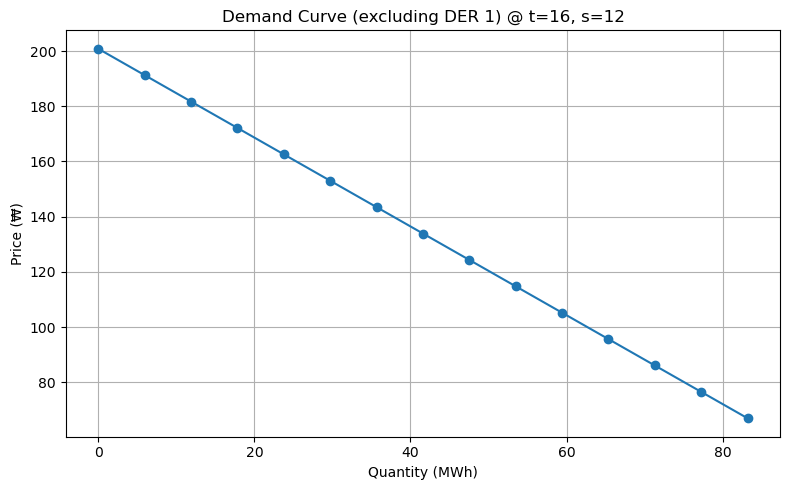

In [46]:
# === 설정 ===
target_i = 1  # RDC를 도출할 대상 DER
t, s = 16, 12   # 시간/시나리오 인덱스

# === Step 1: DER 0을 제외한 total internal demand 계산 ===
total_demand = sum(ym_vals[i, t, s] for i in range(I) if i != target_i)

# === Step 2: DER 0 제외하고 내부 정산 수익 계산 ===
given = 0  # 전체 공급 정산 (P_PN 기준)
received = 0  # 전체 수요 정산 (P_RT 기준)

for i in range(I):
    for j in range(I):
        if i == j:
            continue  # 자기 자신은 건너뜀
        given += d_vals[i, j, t, s] * P_PN[t]      # 공급자(i)가 j에게 공급 → 수익
        received += d_vals[j, i, t, s] * P_RT[t, s]    # 수요자(i)가 j에게 공급받음 → 비용

internal_profit = given - received

# === Step 3: 평균 정산 단가 계산 ===
rho_avg = internal_profit / total_demand if total_demand > 0 else 0

# === Step 4: 수요곡선 ===
N = 15
x_min = 0
x_max = 1.6 * total_demand
rho_min = rho_avg - 30
rho_max = rho_avg + 30

rho_min = 0.5 * rho_avg
rho_max = 1.5 * rho_avg 

quantities = np.linspace(x_min, x_max, N)
prices = np.linspace(rho_max, rho_min, N)

demand_curve = list(zip(quantities, prices))

demand_df = pd.DataFrame(demand_curve, columns=["Quantity (d)", "Price (ρ)"])

# === 정보 출력 ===
print(f"[수요곡선 생성 @ t={t}, s={s}]")
print(f"- 타겟 DER: {target_i}")
print(f"- 타겟 제외 총 수요량: {total_demand:.2f} MWh")
for i in range(I):
    demand = ym_vals[i, t, s]
    mark = "  <-- 제외됨" if i == target_i else ""
    print(f"  DER {i}: {demand:.2f} MWh {mark}")
print(f"- 수요곡선 범위: {x_min:.1f} ~ {x_max:.1f} MWh")
print(f"- 평균 정산 단가: {rho_avg:.2f} ₩")
print(f"- 가격 범위 (ρ): {rho_max:.2f} ₩ → {rho_min:.2f} ₩\n")

print(demand_df)

plt.figure(figsize=(8, 5))
plt.plot(demand_df["Quantity (d)"], demand_df["Price (ρ)"], marker='o', linestyle='-')

plt.title(f"Demand Curve (excluding DER {target_i}) @ t={t}, s={s}")
plt.xlabel("Quantity (MWh)")
plt.ylabel("Price (₩)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Supply Curve w/o i*

#### Optimization w/o i*

In [53]:
I_set = [i for i in range(I) if i != target_i]
M1 = np.maximum(R[I_set], K[I_set, None, None]).max()
M2 = max(R[I_set].sum(axis=0).max(), K[I_set].sum())

model = gp.Model(f"set_without_{target_i}")
model.setParam("MIPGap", 1e-7)

# 변수 정의
x = model.addVars(I_set, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
yp = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = model.addVars(I_set, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = model.addVars(I_set, I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p1")
p2 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p2")
p3 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p3")
p4 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p4")

model.update()

# 목적함수
obj = gp.quicksum(P_DA[t] * x[i, t] for i in I_set for t in range(T)) + gp.quicksum(
    (1 / S) * (
        P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in I_set) -
        P_PN[t] * gp.quicksum(em[i, t, s] for i in I_set)
    )
    for t in range(T) for s in range(S)
)
model.setObjective(obj, GRB.MAXIMIZE)

# 제약조건
for i, t, s in product(I_set, range(T), range(S)):
    model.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    model.addConstr(yp[i, t, s] <= R[i, t, s])
    model.addConstr(zd[i, t, s] <= z[i, t, s])
    model.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    model.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    model.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    model.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    model.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    model.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    model.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    model.addConstr(z[i, t, s] <= K[i])
    model.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])

for i, s in product(I_set, range(S)):
    model.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(I_set, range(T), range(S)):
    model.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in I_set if j != i))
    model.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in I_set if j != i))
    model.addConstr(gp.quicksum(ep[i, t, s] for i in I_set) <= M2 * p4[i, t, s])
    model.addConstr(gp.quicksum(em[i, t, s] for i in I_set) <= M2 * (1 - p4[i, t, s]))
    model.addConstr(d[i, i, t, s] == 0)

# 최적화
model.optimize()

x_vals = np.array([[x[i, t].X for t in range(T)] for i in I_set])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in I_set] for i in I_set])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 16360 rows, 12568 columns and 38440 nonzeros
Model fingerprint: 0xb3675bfd
Variable types: 8728 continuous, 3840 integer (3840 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 9644 rows and 6840 columns
Presolve time: 0.04s
Presolved: 6716 rows, 5728 columns, 19785 nonzeros
Variable types: 3609 continuous, 2119 integer (2119 binary)
Found heuristic solution: objective 237703.29242

Root relaxation: objective 3.880943e+05, 4740 iterations, 0.10 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

[공급곡선 @ t=16, s=12] - Target DER: 1
   Cumulative Supply (d)  Price (ρ)
0                  0.000    297.014
1                  4.000    267.014
2                  9.000    257.014


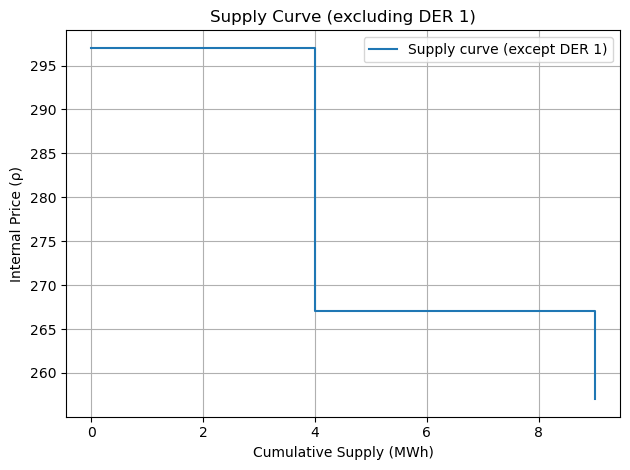

In [56]:
# === 설정 ===
t, s = 16, 12
target_i = 1
I_set = [i for i in range(I) if i != target_i]
i_map = {i: idx for idx, i in enumerate(I_set)}  # 실제 index → 내부 index 매핑

# === Step 1: 공급자 i의 총 공급량 d_ij 계산 ===
supply_list = []

for i in I_set:
    i_idx = i_map[i]
    supplied = sum(
        d_vals[i_idx, i_map[j], t, s]
        for j in I_set if j != i
    )
    if supplied > 1e-4:
        supply_list.append((supplied, i))

supply_list.sort()

# === Step 2: 계단형 공급곡선 구성 ===
quantities = [0]
prices = [P_PN[t] + 30]

for q, i in supply_list:
    quantities.append(quantities[-1] + q)
    prices.append(P_PN[t])  # 단일 가격

quantities.append(quantities[-1] + 5)
prices.append(P_PN[t] - 10)

# === Step 3: 시각화 ===
import matplotlib.pyplot as plt
import pandas as pd

supply_df = pd.DataFrame({
    "Cumulative Supply (d)": quantities,
    "Price (ρ)": prices
})

print(f"[공급곡선 @ t={t}, s={s}] - Target DER: {target_i}")
print(supply_df)

plt.step(quantities, prices, where="post", label=f"Supply curve (except DER {target_i})")
plt.xlabel("Cumulative Supply (MWh)")
plt.ylabel("Internal Price (ρ)")
plt.title(f"Supply Curve (excluding DER {target_i})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()